# Task performance and engagement model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import binned_statistic
from matplotlib import colors
from matplotlib.lines import Line2D
import random
import json
from datetime import datetime, timedelta
from scipy.stats import norm, weibull_min

In [2]:
# Increase figure size a bit
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams.update({'font.size': 16})

### Model simulations

In [3]:
# Set up and run the model

# Simulation parameters
n_users = 1000000
initial_elos = np.random.normal(-50, 150, n_users)

# Learning parameters
lr_all = np.random.uniform(low=0, high=.005, size=(n_users,))
decay_all = np.random.uniform(low=0, high=.00001, size=(n_users,))
sigma_noise = 20

w_1 = -.05
w_2 = .00005
w_3 = .001
elo_ref = 0
sigma_igi = 2.5

# Boundary conditions
ceiling_elo = 600
floor_elo = -600

# Save out variables of interest
elo_all = [[] for x in range(n_users)]
igi_all = [[] for x in range(n_users)]
time_all = [[] for x in range(n_users)]

# Iterate over the period of games
for user in range(n_users):
    time_counter = 0
    game_counter = 0
    curr_elo = initial_elos[user]
    elo_all[user].append(curr_elo)
    delta_elo = 0
    
    lr = lr_all[user]
    decay = decay_all[user]
    while time_counter < 250:
        
        # Predict the IGI
        mu_igi = w_1*game_counter + w_2*(curr_elo-elo_ref)**2 + w_3*delta_elo
        igi = np.random.lognormal(mu_igi, sigma_igi) + 0.1
        igi_all[user].append(igi)

        # Play a game, which leads to a rating change
        curr_noise = np.random.normal(0, sigma_noise)
        elo_change = lr*(ceiling_elo-curr_elo)+curr_noise
        curr_elo += elo_change
        curr_elo -= igi*decay*(curr_elo-floor_elo)
        
        # Save out rating change and IGI
        elo_all[user].append(curr_elo)
        block = min(len(elo_all[user]),20)
        delta_elo = elo_all[user][-1]-elo_all[user][-block]
        igi_all[user].append(igi)
        time_counter += igi
        time_all[user].append(time_counter)
        game_counter += 1

In [6]:
# Compute result 1
final_elo_rating = []
final_total_games = []
for i in range(n_users):
    elo_rating = elo_all[i][-1]
    final_elo_rating.append(elo_rating)
    total_games = len(elo_all[i])
    final_total_games.append(total_games)

In [7]:
# Stats
st.spearmanr(final_total_games, final_elo_rating)

SpearmanrResult(correlation=0.43784278225257606, pvalue=0.0)

/Users/ionatankuperwajs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  


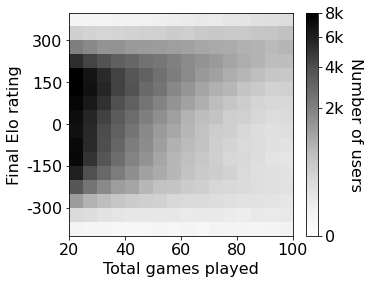

In [8]:
# Plot
heatmap, xedges, yedges = np.histogram2d(final_total_games, final_elo_rating, range=[[20, 100], [-400, 400]], bins=16)

fig, ax = plt.subplots()

im = ax.imshow(heatmap.T, interpolation='nearest', origin='lower', cmap='Greys', vmin=0, vmax=8000, norm=colors.PowerNorm(gamma=0.4))
ax.set_xlabel('Total games played')
ax.set_ylabel('Final Elo rating')
ax.set_xticks(np.arange(0-.5,20-.5,4))
ax.set_xticklabels(['20', '40', '60', '80', '100'])
ax.set_yticks(np.arange(0+1.5,16,3))
ax.set_yticklabels(['-300', '-150', '0', '150', '300'])

colorbar = plt.colorbar(im, shrink=0.82)
colorbar.ax.set_ylabel('Number of users', rotation=-90, va="bottom")
colorbar.set_ticks(np.arange(0,8000+1,2000))
colorbar.set_ticklabels(['0','2k', '4k', '6k', '8k'])

# ax.set_aspect(0.28)

plt.show()
# plt.savefig('sim_elos_final_heatmap.png', format='png', dpi=1000,bbox_inches = 'tight')

In [42]:
# Compute result 2
block20 = []
block40 = [[],[]]
block60 = [[],[],[]]
block80 = [[],[],[],[]]
block100 = [[],[],[],[],[]]

for i in range(n_users):
    total_games = len(elo_all[i])
    block = int(np.floor(total_games/20))
    for j in range(block):
        curr_rating = elo_all[i][j*20]
        if block == 1:
            block20.append(curr_rating)
        elif block == 2:
            block40[j].append(curr_rating)
        elif block == 3:
            block60[j].append(curr_rating)
        elif block == 4:
            block80[j].append(curr_rating)
        elif block == 5:
            block100[j].append(curr_rating)

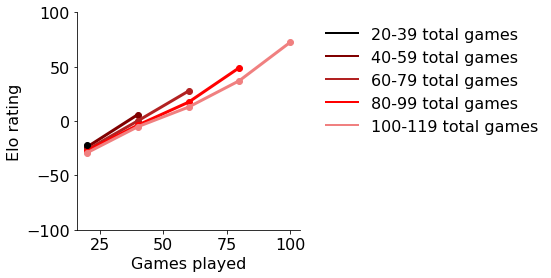

In [43]:
# Plot
colors_list = ['black', 'maroon', 'firebrick', 'red', 'lightcoral']

fig, ax = plt.subplots(figsize=(4,4))
legend_elements = [Line2D([0], [0], color=colors_list[0], lw=2, label='20-39 total games'),Line2D([0], [0], color=colors_list[1], lw=2, label='40-59 total games'), Line2D([0], [0], color=colors_list[2], lw=2, label='60-79 total games'), Line2D([0], [0], color=colors_list[3], lw=2, label='80-99 total games'),Line2D([0], [0], color=colors_list[4], lw=2, label='100-119 total games')]
ax.legend(handles=legend_elements, frameon = False, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.errorbar([20,40], np.average(block40,axis=1), yerr = st.sem(block40,axis=1), marker='o', color='maroon', lw=3)
ax.errorbar([20,40,60], np.average(block60,axis=1),yerr = st.sem(block60,axis=1), marker='o', color='firebrick', lw=3)
ax.errorbar([20,40,60,80], np.average(block80,axis=1), yerr = st.sem(block80,axis=1), marker='o', color='red', lw=3)
ax.errorbar([20,40,60,80,100], np.average(block100,axis=1), yerr = st.sem(block100,axis=1), marker='o', color='lightcoral',lw=3)
ax.errorbar([20], np.average(block20), yerr = st.sem(block20), marker='o', color='black', lw=3)
ax.set_ylabel('Elo rating')
ax.set_xlabel('Games played')
ax.set_yticks([-100, -50, 0, 50, 100])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('sim_learning.png', format='png', dpi=1000,bbox_inches = 'tight')

In [13]:
# Compute result 3
games_played = []
stopping = []

for j in range(len(elo_all)):
    if len(elo_all) > 20:
        curr_trajectory = elo_all[j][::20]
        for i in range(len(curr_trajectory)):
            games_played.append(i*20+20)
            if i != len(curr_trajectory)-1:
                stopping.append(0)
            else:
                stopping.append(1)

In [14]:
# Compute the mean and sem binned for stopping vs. games played
bin_means, bin_edges, binnumber = binned_statistic(games_played, stopping, statistic='mean', bins=10, range=(0, 200))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(games_played, stopping, statistic=st.sem, bins=10, range=(0, 200))

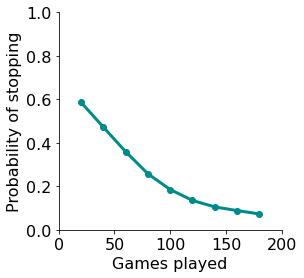

In [15]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))
ax.errorbar(bin_edges[:-1], bin_means, marker='o', color='darkcyan', lw=3)
ax.fill_between(bin_edges[:-1], bin_means-bin_sem, bin_means+bin_sem, color='darkcyan', alpha=0.2)
ax.set_ylabel('Probability of stopping')
ax.set_xlabel('Games played')
ax.set_ylim(0,1)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('sim_stopping_games.png', format='png', dpi=1000,bbox_inches = 'tight')

In [98]:
# Compute result 4
elos = []
stopping = []

for j in range(len(elo_all)):
    if len(elo_all) > 20:
        curr_trajectory = elo_all[j][::20]
        for i in range(len(curr_trajectory)):
            elos.append(curr_trajectory[i])
            if i != len(curr_trajectory)-1:
                stopping.append(0)
            else:
                stopping.append(1)

In [99]:
# Compute the mean and sem binned for stopping vs. elo
bin_means, bin_edges, binnumber = binned_statistic(elos, stopping, statistic='mean', bins=10, range=(-200, 200))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(elos, stopping, statistic=st.sem, bins=10, range=(-200, 200))

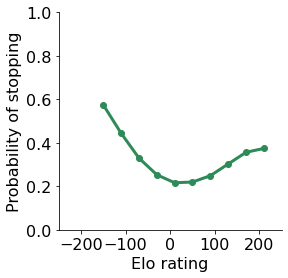

In [100]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))
ax.errorbar(bin_edges[:-1]+50, bin_means, marker='o', color='seagreen', lw=3)
ax.fill_between(bin_edges[:-1]+50, bin_means-bin_sem, bin_means+bin_sem, color='seagreen', alpha=0.2)
ax.set_ylabel('Probability of stopping')
ax.set_xlabel('Elo rating')
ax.set_xlim(-250,250)
ax.set_ylim(0,1)
ax.set_xticks([-200, -100, 0, 100, 200])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('sim_stopping_elo.png', format='png', dpi=1000,bbox_inches = 'tight')

In [19]:
# Compute result 5
change_elos = []
stopping = []

for j in range(len(elo_all)):
    if len(elo_all) > 20:
        curr_trajectory = elo_all[j][::20]
        for i in range(len(curr_trajectory)):
            if i == 0:
                pass
            else:
                change_elos.append(curr_trajectory[i]-curr_trajectory[i-1])
                if i != len(curr_trajectory)-1:
                    stopping.append(0)
                else:
                    stopping.append(1)

In [20]:
# Compute the mean and sem binned for stopping vs. change in elo
bin_means, bin_edges, binnumber = binned_statistic(change_elos, stopping, statistic='mean', bins=10, range=(-200, 200))
bin_sem, bin_edges_sem, binnumber_sem = binned_statistic(change_elos, stopping, statistic=st.sem, bins=10, range=(-200, 200))

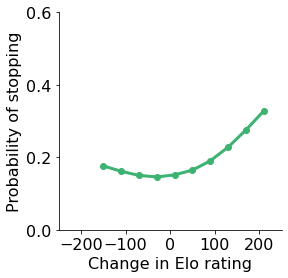

In [94]:
# Plot
fig, ax = plt.subplots(figsize=(4,4))
ax.errorbar(bin_edges[:-1]+50, bin_means, marker='o', color='mediumseagreen', lw=3)
ax.fill_between(bin_edges[:-1]+50, bin_means-bin_sem, bin_means+bin_sem, color='mediumseagreen', alpha=0.2)
ax.set_ylabel('Probability of stopping')
ax.set_xlabel('Change in Elo rating')
ax.set_xlim(-250,250)
ax.set_ylim(0,0.6)
ax.set_xticks([-200, -100, 0, 100, 200])
ax.set_yticks([0, 0.2, 0.4, 0.6])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('sim_stopping_change.png', format='png', dpi=1000,bbox_inches = 'tight')

In [86]:
# Compute result 6
time_filt = [sublist for sublist in time_all if len(sublist) >= 20 and len(sublist) <= 100]
raster_sample = random.sample(time_filt, 50)
raster_sample.sort(key = len)
raster_sample = [[ele for ele in sub if ele != 0] for sub in raster_sample]

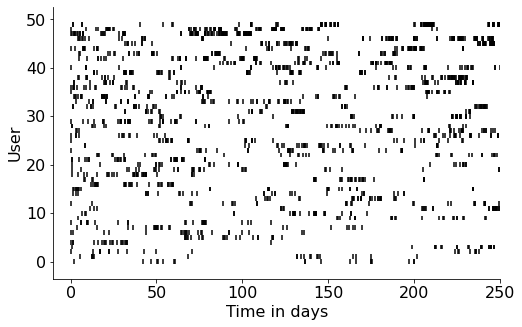

In [88]:
# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.eventplot(raster_sample, color='black')

ax.set_xlim(-10,250)
ax.set_xticks([0, 50, 100, 150, 200, 250])
ax.set_xlabel('Time in days')
ax.set_ylabel('User')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('sim_raster.png', format='png', dpi=1000,bbox_inches = 'tight')

In [89]:
# Compute supplementary result 1
IGI_stds = []
IGI_means = []

igi_filt = [sublist for sublist in igi_all if len(sublist) >= 20]
for user in range(len(igi_filt)):
    user_IGI = igi_filt[user]
    IGI_stds.append(np.std(user_IGI))
    IGI_means.append(np.average(user_IGI))

In [90]:
IGI_coeff = np.asarray(IGI_stds)/np.asarray(IGI_means)

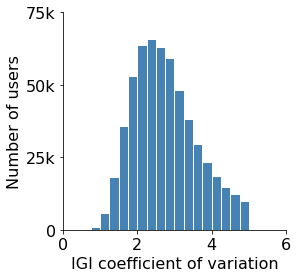

In [92]:
# Plot
bins = list(np.arange(0,5.01,0.25))

fig, ax = plt.subplots(figsize=(4,4))
ax.hist(IGI_coeff, bins, edgecolor='white', color='steelblue')
ax.set_xlabel('IGI coefficient of variation')
ax.set_ylabel('Number of users')
ax.set_xlim(0,5)
ax.set_xticks([0, 2, 4, 6])
ax.set_yticks([0, 25000, 50000, 75000])
ax.set_yticklabels(['0', '25k', '50k', '75k'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
# plt.savefig('sim_coeff_distribution.png', format='png', dpi=1000,bbox_inches = 'tight')